In [1]:

l = nx.laplacian_matrix(adj).todense()
L = nx.laplacian_matrix(G)
nL = csgraph.laplacian(l, normed=True)
degrees = dict(nx.degree(adj))
D = np.diag(list(degrees.values()))

A = nx.adjacency_matrix(adj)
A_dense = A.toarray()

normalized_gl = (D-A_dense)/2.19890275e+03

import numpy as np
from scipy.linalg import eigh
# compute the eigenvalues and eigenvectors of the Laplacian matrix
eps = 1e-8  # small positive constant
evals, evecs = eigh(normalized_gl, eigvals=(0, 76))




eigenvalues, eigenvectors = np.linalg.eigh(l)
sort_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sort_indices]
eigenvectors = eigenvectors[:, sort_indices]

def conv_matrix(x, days=14):
    output = np.zeros(shape=(days, 77, 77))
    for i in range(days-1):
        output[i,:,:] = np.corrcoef(x[:, :i])
    return output
conv_matrix_input = conv_matrix(x_matrix)

: 

: 

In [1412]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_style('whitegrid')
mpl.rc("figure", dpi=120)

In [1059]:
loader = DataLoader('save.csv', 20, 28*2, 14, 7)
a,b,c,d = loader.train_test_split()

In [13]:
import os
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class DataLoader:
    def __init__(self, data_path, adj_datapath, start_day, n_training, n_timesteps, n_pred):
        self.x = pd.read_csv(data_path).to_numpy()
        self.adj_datapath = adj_datapath
        self.start_day = start_day
        self.n_timesteps = n_timesteps
        self.n_training = n_training
        self.n_pred = n_pred
        self.n_batch = n_training-n_timesteps-n_pred

    def concat_raw_data(self):
        # Concatenate all data in the folder: data_for_adjc_20230414updated into one file
        # List of the CSV file names
        csv_files = ['jan2020.csv', 'feb2020.csv', 'mar2020.csv', 'apr2020.csv', 'may2020.csv',
                     'jun2020.csv', 'jul2020.csv', 'aug2020.csv', 'sep2020.csv', 'oct2020.csv',
                     'nov2020.csv', 'dec2020.csv']
        # Read each CSV file into a DataFrame and store them in a list
        dataframes = [pd.read_csv(os.path.join(self.adj_datapath, file))[['Departure','Arrival','Date']].iloc[:-5] for file in csv_files]
        # Concatenate DataFrames column-wise (axis=1)
        combined_dataframe = pd.concat(dataframes, axis=0)
        # Sort the DataFrame by Date
        combined_dataframe = combined_dataframe.sort_values(by='Date').reset_index(drop=True)
        return combined_dataframe

    def count_total_flights(self):
        # Create a DataFrame that contains the number of flights between each pair of airports
        df = self.concat_raw_data()
        df = df.groupby(['Departure','Arrival']).size().reset_index(name='Flights')
        # Create a DataFrame that contains the number of flights from each airport
        df_departure = df.groupby('Departure').size().reset_index(name='Departure_Flights')
        # Create a DataFrame that contains the number of flights to each airport
        df_arrival = df.groupby('Arrival').size().reset_index(name='Arrival_Flights')
        # Merge the two DataFrames
        df = pd.merge(df, df_departure, on='Departure')
        df = pd.merge(df, df_arrival, on='Arrival')
        return df

    def creat_adjacency_matrix(self):
        # Create adjacency matrix grouped by every 21 days


        pass

    def train_test_split(self):
        self.train = self.x[:,self.start_day:self.start_day+self.n_training]
        self.scale = StandardScaler()
        self.train = self.scale.fit_transform(self.train.T).T
        self.x_train = np.zeros(shape=(self.n_batch, self.n_timesteps, 77))
        self.y_train = np.zeros(shape=(self.n_batch, 77*self.n_pred))
        for i in range(self.n_batch):
            self.x_train[i,:,:] = self.train[:,i:i+self.n_timesteps].T
            self.y_train[i,:] = self.train[:,i+self.n_timesteps:i+self.n_timesteps+self.n_pred].flatten()

        # +1 is added here to resolve the issue that the state of LSTM is 0 for the first element
        self.test = self.x[:,self.start_day+self.n_pred+1:]
        self.test = self.scale.transform(self.test.T).T
        self.x_test = np.zeros(shape=(self.n_batch, self.n_timesteps, 77))
        for i in range(self.n_batch):
            self.x_test[i,:,:] = self.test[:,i:i+self.n_timesteps].T
        return tf.convert_to_tensor(self.x_train), tf.convert_to_tensor(self.y_train), tf.convert_to_tensor(self.x_test)

# x = pd.read_csv('save.csv').to_numpy()
# scaler = StandardScaler()
# x = scaler.fit_transform(x.T).T

# n_batch = 64
# n_timesteps = 40
# n_pred = 3
# nn_input = np.zeros(shape=(n_batch, n_timesteps, 77))
# nn_output = np.zeros(shape=(n_batch, 77*n_pred))
# for i in range(n_batch):
#     nn_input[i,:,:] = x[:,i:i+n_timesteps].T
#     nn_output[i,:] = x[:,i+n_timesteps:i+n_timesteps+n_pred].flatten()

# nn_input = tf.convert_to_tensor(nn_input)
# nn_output = tf.convert_to_tensor(nn_output)
# # Prepare the output data
# num_output = 77 * n_pred

# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(num_output, batch_input_shape=(n_batch,n_timesteps,77)))
# model.add(Dense(num_output//2, activation='relu'))
# model.add(Dense(num_output, activation='linear'))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(nn_input, nn_output, epochs=100, batch_size=32)

adj_path = os.path.join('..', 'dataset', 'data_for_adjc_20230414updated')
loader = DataLoader('save.csv', adj_path, 40, 28*2, 21, 7)

# combined_df = loader.concat_raw_data()
# total_stats = loader.count_total_flights()





# x_train, y_train, x_test = loader.train_test_split()
#
# model = Sequential()
# model.add(LSTM(loader.n_pred*77, batch_input_shape=(loader.n_batch,loader.n_timesteps,77)))
# model.add(Dense(loader.n_pred*77//2, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(loader.n_pred*77, activation='linear'))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(x_train, y_train, epochs=100, batch_size=14)

,Departure,Arrival,Flights,Departure_Flights,Arrival_Flights
0,ABQ,ATL,263,49,71
1,ANC,ATL,329,53,71
2,AUS,ATL,365,72,71
3,BDL,ATL,366,68,71
4,BHM,ATL,366,51,71
...,...,...,...,...,...
4830,PBI,OXR,2,70,13
4831,SFO,OXR,2,74,13
4832,SJC,OXR,1,69,13
4833,SNA,OXR,2,64,13


In [1471]:
class LSTMoutput:
    def __init__(self, DataLoader, airport_index):
        self.actual = DataLoader.x
        self.n_timesteps = DataLoader.n_timesteps
        self.scale = DataLoader.scale
        self.airport_index = airport_index

        self.n_batch = DataLoader.n_batch
        self.n_training = DataLoader.n_training
        self.n_pred = DataLoader.n_pred
        self.start_day = DataLoader.start_day

    def inverse_transform(self, input):
        self.predicted_transformed = self.scale.inverse_transform(input[-1,:].reshape(77,self.n_pred).T).T[self.airport_index,:]

        self.predicted_transformed = []
        for i in range(self.n_batch):
            traffic = self.scale.inverse_transform(input[i,:].reshape(77,self.n_pred).T).T[self.airport_index, self.n_pred-1]
            self.predicted_transformed.append(traffic)

    def plot(self):
        x_train_start = self.start_day
        y_train_start = self.start_day
        x_train_end = x_train_start + self.n_training
        y_train_end = y_train_start + self.n_training

        x_test_start = self.start_day+self.n_training-1
        x_test_end = x_test_start+self.n_pred+1
        y_test_start = self.start_day+self.n_training-1
        y_test_end = x_test_start+self.n_pred+1

        x_forecast_start = 2*self.n_pred+self.start_day+self.n_timesteps
        x_forecast_end = x_forecast_start + self.n_batch
        
        fig, ax = plt.subplots()
        sns.lineplot(x=np.arange(x_train_start, x_train_end), 
                     y=self.actual[self.airport_index, np.arange(y_train_start, y_train_end)], 
                     label='Training',
                     ax=ax)
        sns.lineplot(x=np.arange(x_test_start, x_test_end), 
                     y=self.actual[self.airport_index, np.arange(y_test_start, y_test_end)], 
                     label='Testing - Actual',
                     ax=ax)
        sns.lineplot(x=np.arange(x_forecast_start, x_forecast_end), 
                     y=self.predicted_transformed, 
                     color='red', 
                     marker='o', 
                     ms=5, 
                     label='Testing - Predicted',
                     ax=ax)
        ax.set(title='LSTM Forecast for ATL',
               ylim=(0,1600), 
               xlim=(x_train_start, x_forecast_end+7))
        plt.axvline(x=x_train_end-1, color='black', linestyle='--', linewidth=0.75)
        plt.legend()

        # padded = np.pad(np.array(self.pred_transformed), (self.n_timesteps, 0))
        # self.padded = padded
        # value = np.append(padded, actual)
        # self.value = value
        # day = np.tile(np.arange(1, self.n_timesteps+self.n_batch+1), (2))
        # type = np.concatenate((np.array(['Predicted']*(self.n_timesteps+self.n_batch)), np.array(['Actual']*(self.n_timesteps+self.n_batch))))
        # atl_plot = pd.DataFrame(np.vstack((value, day, type)).T)
        # atl_plot.columns = ['Value', 'Day', 'Type']
        # atl_plot[['Value', 'Day']] = atl_plot[['Value', 'Day']].astype(float)
        # fig, ax = plt.subplots()
        # sns.lineplot(data=atl_plot, x='Day', y='Value', hue='Type', ax=ax)
        # ax.set(title='ATL Throughput - Training Results', xlabel='Days Since 1/1/20', ylabel='# of Flights')

1/1 [==============================] - 0s 35ms/step


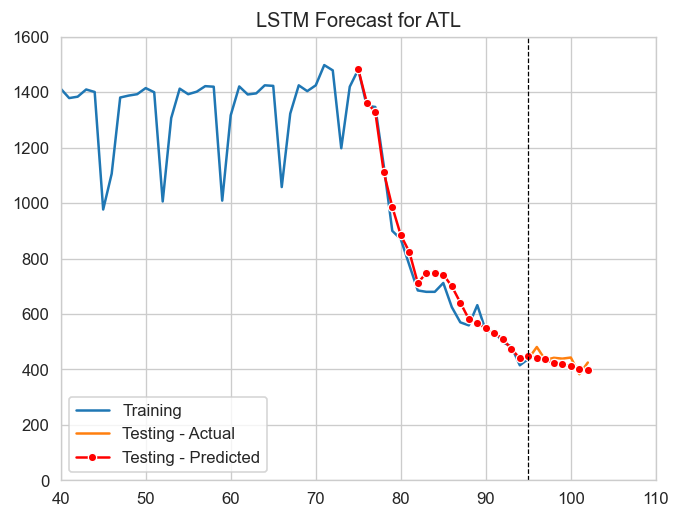

In [1483]:
predicted = model.predict(x_test)
result = LSTMoutput(loader, 2)
result.inverse_transform(predicted)
result.plot()

In [1481]:
check[4:6]

array([4, 5])

In [709]:
padded = np.pad(np.array(pred_transformed_atl), (40,0))
value = np.append(padded, x[2,:40+64])
day = np.tile(np.arange(1,105),(2))
type = np.concatenate((np.array(['Predicted']*104), np.array(['Actual']*104)))
atl_plot = pd.DataFrame(np.vstack((value, day, type)).T)
atl_plot.columns = ['Value', 'Day', 'Type']
atl_plot[['Value', 'Day']] = atl_plot[['Value', 'Day']].astype(float)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 120 and the array at index 1 has size 208

[Text(0.5, 1.0, 'ATL Throughput - Training Results'),
 Text(0.5, 0, 'Days Since 1/1/20'),
 Text(0, 0.5, '# of Flights')]

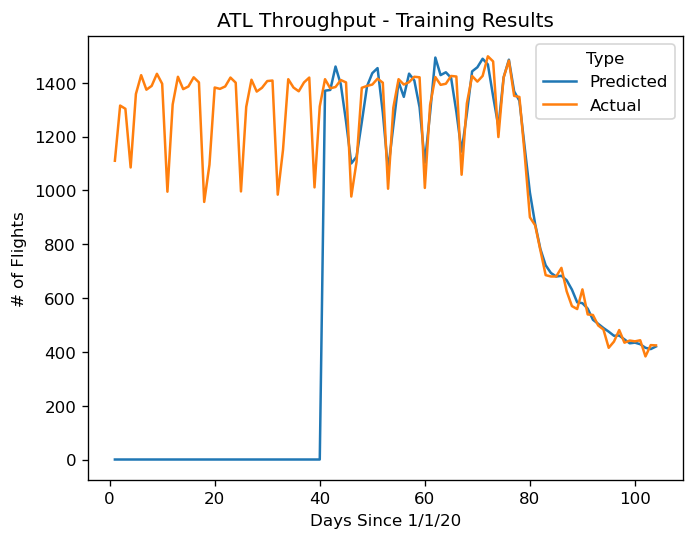

In [669]:
fig, ax = plt.subplots()
sns.lineplot(data=atl_plot, x='Day', y='Value', hue='Type', ax=ax)
ax.set(title='ATL Throughput - Training Results', xlabel='Days Since 1/1/20', ylabel='# of Flights')

In [644]:
x = pd.read_csv('save.csv').to_numpy()
scaler = StandardScaler()
x = scaler.fit_transform(x)
testing_input = np.zeros(shape=(n_batch, n_timesteps, 77))
for i in range(n_batch):
    testing_input[i,:,:] = x[:,i+17:i+17+n_timesteps].T

In [624]:
testing_results = model.predict(testing_input)

2/2 [==============================] - 0s 13ms/step


In [629]:
testing_atl = []
for i in range(64):
    a = LSTMoutput(40+17+i)
    traffic = a.inverse_transform(testing_results[i,:],0)[2,0]
    testing_atl.append(traffic)

In [631]:
x = pd.read_csv('save.csv').to_numpy()
padded = np.pad(np.array(testing_atl), (57,0))
value = np.append(padded, x[2,:57+64])
day = np.tile(np.arange(1,122),(2))
type = np.concatenate((np.array(['Predicted']*121), np.array(['Actual']*121)))
atl_plot = pd.DataFrame(np.vstack((value, day, type)).T)
atl_plot.columns = ['Value', 'Day', 'Type']
atl_plot[['Value', 'Day']] = atl_plot[['Value', 'Day']].astype(float)

[Text(0.5, 1.0, 'ATL Throughput - Testing Results'),
 Text(0.5, 0, 'Days Since 1/1/20'),
 Text(0, 0.5, '# of Flights')]

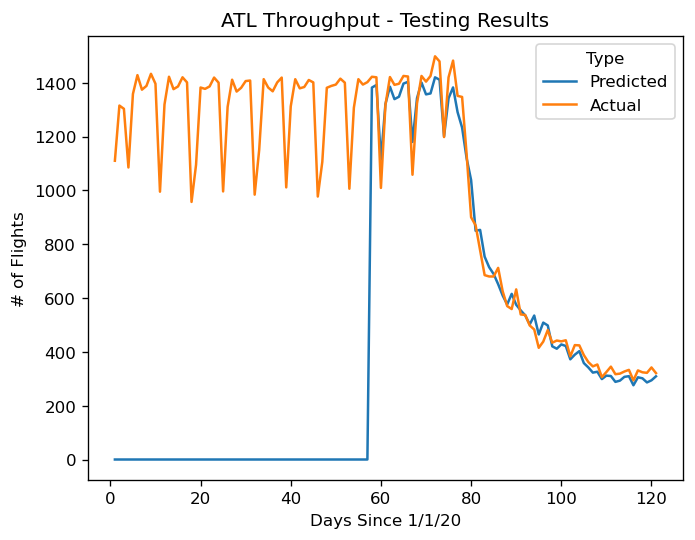

In [632]:
fig, ax = plt.subplots()
sns.lineplot(data=atl_plot, x='Day', y='Value', hue='Type', ax=ax)
ax.set(title='ATL Throughput - Testing Results', xlabel='Days Since 1/1/20', ylabel='# of Flights')